# Use XGBoost to create new models, do vector ops, apply to test datasets and whole tiles

This notebook starts from the probability maps that were created in RunCNN.ipynb. It:

1) Creates an ensemble average probability map for each training and test region (9 individual maps --> 1 map)
2) Uses them along with imaging spectroscopy and the canopy height maps to train a gradient boosting trees model
3) Produces updated maps, then applies vector operations to further refine the maps
4) Applies the trained model to the entire ~3000 sq km study region (consisting of 3 sub-regions)

Note that this final run-through uses files that were written in previous runs, rather than re-training models etc. That means you won't see the output from every step, but the structure/workflow and important stats, plots, etc. are still there.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import shutil
import glob
import json
import pickle
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import run_xgb
import apply_to_tiles

base_path = '/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/bfgn_output_buildings2/model_runs/'
analysis_path = '/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/bfgn_output_buildings2/analysis/'
model_paths = sorted(glob.glob(base_path+'combo_*'))

/home/remason2/.conda/envs/xgboost/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
Test datasets are labelled datasets not involved in training, which will be used for assessing map
quality (calculating performance stats). Training datasets will not be used for stats, but will be
used as input to the XGB models that reduce false positive building detections.

The contents of the test_sets and training_sets variables must match those in RunCNN.ipynb. If I had more time I
would define these in a config file and also use a better naming convention.
"""

test_sets = {'HBTest': 'HBTest',\
                       'HOVE2': 'tile031_2500_11250',\
                       'MIL2': 'tile030_9375_5625',\
                       'CC2': 'tile024_10000_2500',\
                       'SKona_A': 'SKona_TestA',\
                       'SKona_B': 'SKona_TestB',\
                       'Hamakua_A': 'Hamakua_testA',\
                       'Puako': 'Puako',\
                       'KonaMauka': 'KonaMauka'}

training_sets = {'HBLower': 'HBLower',\
                           'HOVE1': 'tile031_3125_11250',\
                           'CC1': 'tile024_10000_3125',\
                           'MIL1': 'tile030_10000_5625',\
                           'Hamakua': 'tile016_0_4375',\
                           'KParadise': 'KParadise',\
                           'CCTrees': 'tile024_10000_4375',\
                           'WAI1': 'Waikoloa1',\
                           'KK1': 'Kukio1',\
                           'Waimea': 'Waimea'}

all_labelled_data = {**test_sets, **training_sets}

In [3]:
utils = run_xgb.Utils(all_labelled_data)

manips = run_xgb.MapManips(model_output_root=base_path, all_labelled_data=all_labelled_data)

stats = run_xgb.Stats(model_output_root=base_path, test_sets=test_sets,\
                          all_labelled_data=all_labelled_data,\
                          analysis_path=analysis_path)

ensemble = run_xgb.Ensemble(model_output_root=base_path, test_sets=test_sets,\
                                ensemble_path=base_path+'ensembles/',\
                                all_labelled_data=all_labelled_data)

evalz = run_xgb.Evaluate(model_output_root=base_path, training_sets=training_sets,\
                             test_sets = test_sets, all_labelled_data=all_labelled_data)

model_dir = f'{base_path}ensembles/'

#test regions - these maps will be displayed after different steps
regions_to_show = ['HBTest', 'Puako', 'KonaMauka', 'Hamakua_A']

In [4]:
%%script echo skipping (files exist)
"""
Remove buildings < 50 sq m from training and test sets, as described in Methods section of paper
"""

utils.remove_small_buildings(outpath='buildings2/', minsize=50)

skipping (files exist)


## Make ensemble CNN probability maps, and binary building/not-building maps

We start by taking the 9 individual CNN-based probability maps for each training and test region, and combining
them into a single average map for each region.

In [5]:
%%script echo skipping (files exist)

for region in all_labelled_data.keys():
    ensemble.average_probabilities(model_nums=[0, 1, 2, 3, 4, 5, 6, 7, 8], model_kind='CNN',\
                                   region=region, show=True)

skipping (files exist)


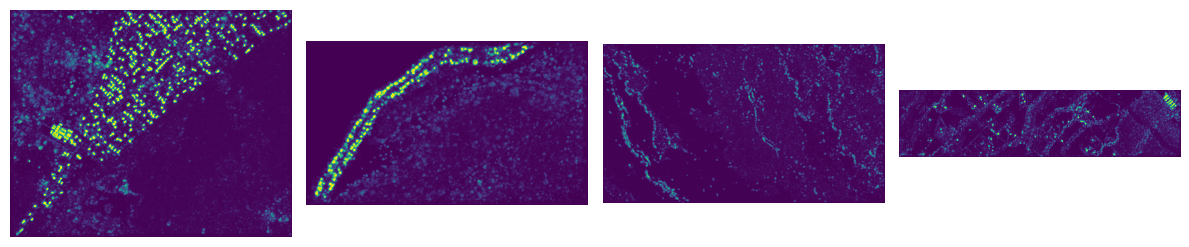

In [6]:
"""
The ensemble maps of four of the test regions. In the two left panels, houses in the Hawaiian Beaches and Puako subdivisions
are clearly visible, but the model has also identified surrounding trees as buildings. In the Hamakua_A and KonaMauka regions,
surface features in lava flows and pasture land have also been identified as buildings. Later we will show the same regions
after running the XGBoost model, to show how they are 'cleaned up' in that step.
"""

_, axes = plt.subplots(1, 4, figsize=(12, 4))

for region, ax in zip(regions_to_show, axes):
    with rasterio.open(f'{model_dir}mean_probability_{region}.tif', 'r') as f:
        img = f.read()
        ax.imshow(img[0])
        ax.axis('off')
        
plt.tight_layout()
        

The maps created in the previous cell show probabilities, to calculate precision and recall we need to convert them to binary maps. The pixel-wise stats aren't used in the paper, but vector-based stats are quoted in Table 1. See Section 3.2 of the paper for more explanation of these terms.

In [7]:
%%script echo skipping (files exist)
"""
Classify the probability maps as prob. > 0.8 --> building, prob < 0.8 --> not-building. This is pretty arbitrary, which
is why I was reluctant to present stats for each step in the process.
"""

for region in all_labelled_data.keys():
    applied_model = f'{base_path}ensembles/mean_probability_{region}.tif'
    outfile = f'{base_path}ensembles/threshold_{region}.tif'
    manips.probabilities_to_classes(applied_model, outfile, 0.8, verbose=False)

skipping (files exist)


In [8]:
%%time
"""
Stats for building pixels when we classify the probability maps as prob. >0.8 --> building,
prob < 0.8 --> not-building
"""

statsfile = f'{analysis_path}cnn_classified.json'

use_existing = True

if use_existing is False:
    cnn_stats = {}
    cnn_stats['class'] = stats.raster_stats(model_dir, map_kind=f'threshold', regions=test_sets)
    with open(statsfile.replace('tif', 'json'), "w") as f:
        json.dump(cnn_stats, f)

else:
    with open(statsfile) as f:
        cnn_stats = json.load(f)

CPU times: user 0 ns, sys: 1.28 ms, total: 1.28 ms
Wall time: 9.35 ms


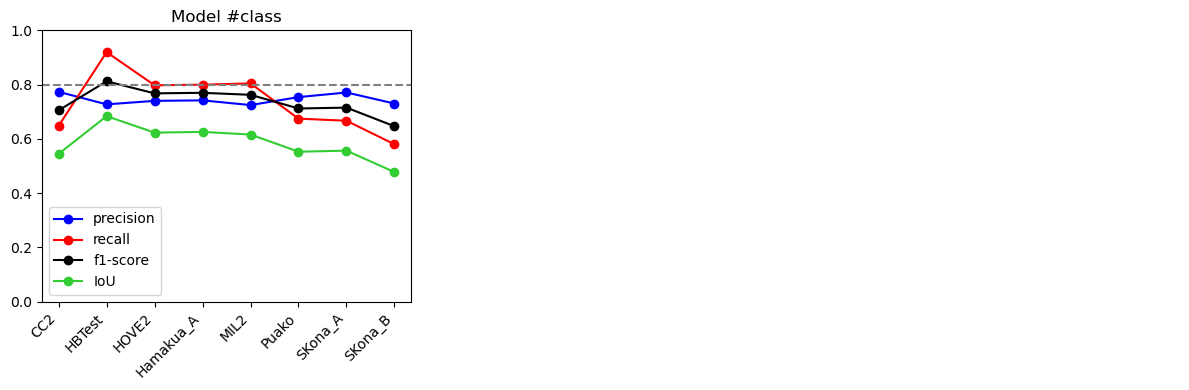

In [9]:
stats.plot_raster_stats(cnn_stats, plot_file='cnn_stats.png')

In [10]:
stats.display_raster_stats(cnn_stats['class'])

,Precision,Recall,F1-score,IoU
CC2,0.77,0.65,0.71,0.54
HBTest,0.73,0.92,0.81,0.68
HOVE2,0.74,0.80,0.77,0.62
Hamakua_A,0.74,0.80,0.77,0.63
MIL2,0.72,0.80,0.76,0.62
Puako,0.75,0.67,0.71,0.55
SKona_A,0.77,0.67,0.72,0.56
SKona_B,0.73,0.58,0.65,0.48
Mean,0.75,0.74,0.74,0.59


In [11]:
"""
Vectorise so we can calculate vector-based stats, to compare with subsequent steps. This is nothing
but vectorizing, no 'cleaning', just for the purpose of getting a consistent set of stats. These stats
(mean values) go in the table in the Results section of the paper.
"""

for region in all_labelled_data.keys():
    map_file = f'{base_path}ensembles/threshold_{region}.tif'
    out_file = f'{base_path}ensembles/threshold_vec_{region}.shp'
    manips.vectorize_only(map_file, out_file)

In [12]:
stats.match_buildings_to_labels(model_dir, map_kind='threshold_vec')
stats.vector_stats(model_dir, map_kind='threshold_vec')

,precision,recall,f1-score
CC2,0.87,0.70,0.77
HBTest,0.96,0.94,0.95
HOVE2,0.95,0.75,0.84
Hamakua_A,0.78,0.84,0.81
MIL2,0.75,0.80,0.77
Puako,0.94,0.80,0.86
SKona_A,0.97,0.67,0.79
SKona_B,0.96,0.56,0.71
Mean,0.90,0.76,0.81


## Create 2m resolution versions of the LiDAR+CNN-based maps

We are going to use the LiDAR+CNN probability maps as input to XGBoost along with imaging spectroscopy. So, the 1m LiDAR-based maps need to be interpolated to the same (2m) pixel size as the spectroscopy data (we already have 2m TCH maps, they were in the processed data package I started from).

In [13]:
%%script echo skipping (files exist)
"""
Create 2m-resolution versions of the LiDAR+CNN-based maps
"""

model_dir = f'{base_path}ensembles/'
feature_dir = '/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/labeled_region_features/'

for region, name in all_labelled_data.items():
    in_file = f'{model_dir}mean_probability_{region}.tif'
    out_file = f'{model_dir}{region}_lores_model.tif'
    template = f'{feature_dir}{name}_tch.tif'
    utils.resample_raster(in_file, out_file, template)

skipping (files exist)


## Reclassify building candidate pixels using a gradient boosting model

This is where we use XGBoost to model CNN-based maps + Canopy height maps + Spectroscopy. We'll do four different runs and average the resulting maps:

1. Brightness-normalized, initial training set
    - The difference between this and the CNN model training set is that I added KonaMauka and SKona_A here. It was probably a mistake not to use the exact same training regions for all model runs. However I think in practice it makes very little difference.
1. As for (1) but slightly different training regions
   - Maps turn out to be very similar to run 1
1. As for (1) but without brightness normalization
    - This seemed to assign lower probability to building pixels, but to assign non-zero probability to more of them.
1. As for (2) but without brignesss normalization

The rationale for modeling spectra with and without brightness normalization is explained in the paper.

In [14]:
#Bands that will be excluded from reflectance dataset
bad_bands = []
for item in [range(0,5), range(94, 117), range(142, 179), [211, 212, 213]]:
    bad_bands.extend(item)

xvars = {'refl': [n for n in range(214) if n not in bad_bands], 'lores_model': ['model_prob'],\
         'tch': ['tch']}

### First run: Brightness normalization, training set 1

In [15]:
"""
Define how this run will be executed
"""

run_id = 'run1'
brightness_norm = True
n_iter = 10

training_sets = {'HOVE1': 'tile031_3125_11250',\
                           'CC1': 'tile024_10000_3125',\
                           'MIL1': 'tile030_10000_5625',\
                           'Hamakua': 'tile016_0_4375',\
                           'KParadise': 'KParadise',\
                           'WAI1': 'Waikoloa1',\
                           'KK1': 'Kukio1',\
                           'Waimea': 'Waimea',\
                           'HBLower': 'HBLower',\
                           'SKona_A': 'SKona_TestA',\
                           'KonaMauka': 'KonaMauka',\
                           'CCTrees': 'tile024_10000_4375'}

test_sets = {'HBTest': 'HBTest',\
                       'HOVE2': 'tile031_2500_11250',\
                       'MIL2': 'tile030_9375_5625',\
                       'CC2': 'tile024_10000_2500',\
                       'Hamakua_A': 'Hamakua_testA',\
                       'Puako': 'Puako',\
                       'SKona_B': 'SKona_TestB'}

all_labelled_data = {**training_sets, **test_sets}


In [16]:
"""
Initialize classes
"""

utils = run_xgb.Utils(all_labelled_data)

manips = run_xgb.MapManips(model_output_root=base_path,\
                               all_labelled_data=all_labelled_data)

evalz = run_xgb.Evaluate(model_output_root=base_path, training_sets=training_sets,\
                             test_sets = test_sets, all_labelled_data=all_labelled_data)

stats = run_xgb.Stats(model_output_root=base_path, test_sets=test_sets,\
                          all_labelled_data=all_labelled_data,\
                          analysis_path=analysis_path)

In [17]:
%%time
"""
Create the dataset to which the GB model will be fit. This contains all pixels from the training data sets, minus
any for which there is no spectroscopy data.
"""

use_existing = True
if use_existing:

    with open(f'{model_dir}X_{run_id}.pkl', "rb") as f:
        X = pickle.load(f)
    with open(f'{model_dir}y_{run_id}.pkl', "rb") as f:
        y = pickle.load(f)
else:
    X, y = evalz.get_vars_from_rasters(xvars=xvars, bad_bands=bad_bands, mask_shade=True,\
                                       bnorm=brightness_norm, model_dir=model_dir, run_id=run_id)


CPU times: user 1.8 s, sys: 19.4 s, total: 21.2 s
Wall time: 40.8 s


In [18]:
%%time
"""
Classify all pixels using XGBOOST
"""

use_existing = True
gb_file = f'{model_dir}gb_{run_id}.pkl'

if use_existing:
    with open(gb_file, "rb") as f:
        gb = pickle.load(f)
else:
    gb = evalz.ml_classify(X, y, n_iter=n_iter, scoring='recall', save_to=gb_file)


[14:41:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/gbm/gbtree.cc:390: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[14:41:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1
CPU times: user 41.4 ms, sys: 1.31 s, total: 1.35 s
Wall time: 4.43 s


In [19]:
%%script echo skipping (files exist)
"""
Calculate feature importances and Shapley values; save SHAPs to file.
Print best hyperparameters, show classification report, ...
"""

#location of X and y split into training and test sets by ml_classify
train_test_file = f'{model_dir}train_test_{run_id}.pkl'

#the file the Shapley values will be written to
shap_file = f'/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/for_figures/shap_{run_id}.pkl'

evalz.ml_metrics(gb, xvars, xy_file=train_test_file, save_to=shap_file)

skipping (files exist)


In [20]:
%%script echo skipping (files exist)
"""
Apply the model to create probability maps, and save as tifs
"""

out_prefix = f'{base_path}ensembles/gb_prob_{run_id}'
manips.gb_prob_to_raster(gb, xvars=xvars, bad_bands=bad_bands, out_prefix=out_prefix,\
                                   model_dir=model_dir, bnorm=brightness_norm)

skipping (files exist)


In [21]:
%%script echo skipping (files exist)

"""
Convert probability maps into binary maps using a (low) threshold
"""

for region in all_labelled_data.keys():
    applied_model = f'{base_path}ensembles/gb_prob_{run_id}_{region}.tif'
    outfile = f'{base_path}ensembles/gb_class_{run_id}_{region}.tif'
    manips.probabilities_to_classes(applied_model, outfile, 0.2, verbose=False)

skipping (files exist)


In [22]:
%%time
"""
Getting pixel-wise performance stats for the binary maps. These were useful when developing the method,
but they aren't reported in the paper.
"""

statsfile = f'{analysis_path}{run_id}_test_sets.json'

use_existing = True

if use_existing is False:
    gb_test_stats = {}
    model_dir = f'{base_path}ensembles/'
    gb_test_stats['XGB classified'] = stats.raster_stats(model_dir, map_kind=f'gb_class_{run_id}',\
                                                         regions=test_sets, resolution='lores_')
    with open(statsfile.replace('tif', 'json'), "w") as f:
        json.dump(gb_test_stats, f)

else:
    with open(statsfile) as f:
        gb_test_stats = json.load(f)

CPU times: user 2.32 ms, sys: 759 µs, total: 3.08 ms
Wall time: 2.28 s


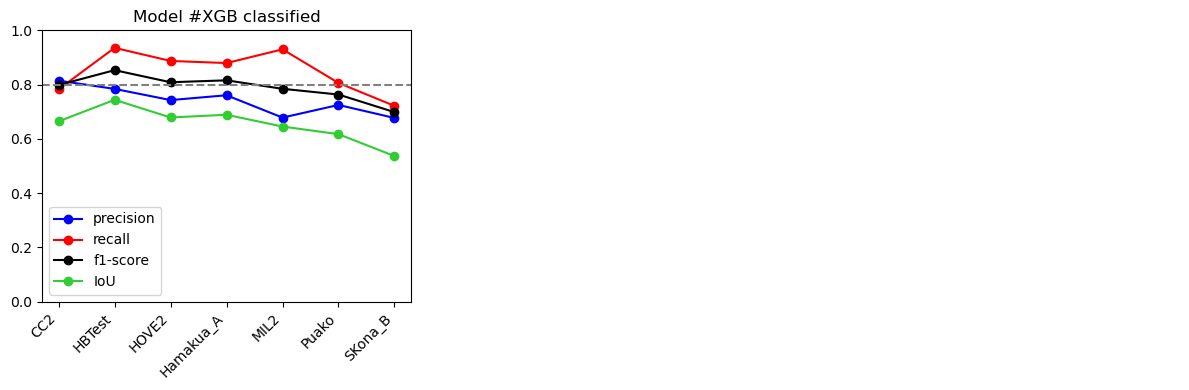

In [23]:
stats.plot_raster_stats(gb_test_stats, plot_file=f'{run_id}_test_stats.png')

In [24]:
stats.display_raster_stats(gb_test_stats['XGB classified'])

,Precision,Recall,F1-score,IoU
CC2,0.81,0.78,0.80,0.66
HBTest,0.78,0.94,0.85,0.74
HOVE2,0.74,0.89,0.81,0.68
Hamakua_A,0.76,0.88,0.82,0.69
MIL2,0.68,0.93,0.78,0.65
Puako,0.73,0.81,0.76,0.62
SKona_B,0.68,0.72,0.70,0.54
Mean,0.74,0.85,0.79,0.65


### Run 2 - brightness normalization, different training set

Same steps as for previous run, except not recreating stats this time (they were very similar)

In [25]:
"""
Define how this run will be executed
"""

run_id = 'run2'
brightness_norm = True
n_iter = 10

training_sets = {'HOVE1': 'tile031_3125_11250',\
                           'CC1': 'tile024_10000_3125',\
                           'MIL1': 'tile030_10000_5625',\
                           'Hamakua': 'tile016_0_4375',\
                           'KParadise': 'KParadise',\
                           'WAI1': 'Waikoloa1',\
                           'KK1': 'Kukio1',\
                           'Waimea': 'Waimea'}

test_sets = {'HBTest': 'HBTest',\
                       'HOVE2': 'tile031_2500_11250',\
                       'MIL2': 'tile030_9375_5625',\
                       'CC2': 'tile024_10000_2500',\
                       'Hamakua_A': 'Hamakua_testA',\
                       'Puako': 'Puako',\
                       'SKona_B': 'SKona_TestB',\
                       'HBLower': 'HBLower',\
                       'SKona_A': 'SKona_TestA',\
                       'KonaMauka': 'KonaMauka',\
                       'CCTrees': 'tile024_10000_4375'}

all_labelled_data = {**training_sets, **test_sets}


utils = run_xgb.Utils(all_labelled_data)

manips = run_xgb.MapManips(model_output_root=base_path,\
                               all_labelled_data=all_labelled_data)

evalz = run_xgb.Evaluate(model_output_root=base_path, training_sets=training_sets,\
                             test_sets = test_sets, all_labelled_data=all_labelled_data)

stats = run_xgb.Stats(model_output_root=base_path, test_sets=test_sets,\
                          all_labelled_data=all_labelled_data,\
                          analysis_path=analysis_path)

In [26]:
use_existing = True

if use_existing:

    with open(f'{model_dir}X_{run_id}.pkl', "rb") as f:
        X = pickle.load(f)
    with open(f'{model_dir}y_{run_id}.pkl', "rb") as f:
        y = pickle.load(f)
else:
    X, y = evalz.get_vars_from_rasters(xvars=xvars, bad_bands=bad_bands, mask_shade=True,\
                                       bnorm=brightness_norm, model_dir=model_dir, run_id=run_id)

In [27]:
use_existing = True

gb_file = f'{model_dir}gb_{run_id}.pkl'

if use_existing:
    with open(gb_file, "rb") as f:
        gb = pickle.load(f)
else:
    gb = evalz.ml_classify(X, y, n_iter=n_iter, scoring='recall', save_to=gb_file)

[14:41:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/gbm/gbtree.cc:390: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[14:41:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


In [28]:
%%script echo skipping (files exist)

train_test_file = f'{model_dir}train_test_{run_id}.pkl'
shap_file = f'/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/for_figures/shap_{run_id}.pkl'
evalz.ml_metrics(gb, xvars, xy_file=train_test_file save_to=shap_file)

skipping (files exist)


In [29]:
%%script echo skipping (files exist)

out_prefix = f'{base_path}ensembles/gb_prob_{run_id}'
manips.gb_prob_to_raster(gb, xvars=xvars, bad_bands=bad_bands, out_prefix=out_prefix,\
                                   model_dir=model_dir, bnorm=brightness_norm)

skipping (files exist)


In [30]:
%%script echo skipping (files exist)

for region in all_labelled_data.keys():
    applied_model = f'{base_path}ensembles/gb_prob_{run_id}_{region}.tif'
    outfile = f'{base_path}ensembles/gb_class_{run_id}_{region}.tif'
    manips.probabilities_to_classes(applied_model, outfile, 0.2, verbose=False)

skipping (files exist)


### Run 3: repeat run 1 without brightness normalization

In [31]:
run_id = 'run3'
brightness_norm = False
n_iter = 10

training_sets = {'HOVE1': 'tile031_3125_11250',\
                           'CC1': 'tile024_10000_3125',\
                           'MIL1': 'tile030_10000_5625',\
                           'Hamakua': 'tile016_0_4375',\
                           'KParadise': 'KParadise',\
                           'WAI1': 'Waikoloa1',\
                           'KK1': 'Kukio1',\
                           'Waimea': 'Waimea',\
                           'HBLower': 'HBLower',\
                           'SKona_A': 'SKona_TestA',\
                           'KonaMauka': 'KonaMauka',\
                           'CCTrees': 'tile024_10000_4375'}

test_sets = {'HBTest': 'HBTest',\
                       'HOVE2': 'tile031_2500_11250',\
                       'MIL2': 'tile030_9375_5625',\
                       'CC2': 'tile024_10000_2500',\
                       'Hamakua_A': 'Hamakua_testA',\
                       'Puako': 'Puako',\
                       'SKona_B': 'SKona_TestB'}

all_labelled_data = {**training_sets, **test_sets}

utils = run_xgb.Utils(all_labelled_data)

manips = run_xgb.MapManips(model_output_root=base_path,\
                               all_labelled_data=all_labelled_data)

evalz = run_xgb.Evaluate(model_output_root=base_path, training_sets=training_sets,\
                             test_sets = test_sets, all_labelled_data=all_labelled_data)

stats = run_xgb.Stats(model_output_root=base_path, test_sets=test_sets,\
                          all_labelled_data=all_labelled_data,\
                          analysis_path=analysis_path)

In [32]:
use_existing = True

if use_existing:

    with open(f'{model_dir}X_{run_id}.pkl', "rb") as f:
        X = pickle.load(f)
    with open(f'{model_dir}y_{run_id}.pkl', "rb") as f:
        y = pickle.load(f)
else:
    X, y = evalz.get_vars_from_rasters(xvars=xvars, bad_bands=bad_bands, mask_shade=True,\
                                       bnorm=brightness_norm, model_dir=model_dir, run_id=run_id)

In [33]:
use_existing = True  

gb_file = f'{model_dir}gb_{run_id}.pkl'

if use_existing:
    with open(gb_file, "rb") as f:
        gb = pickle.load(f)
else:
    gb = evalz.ml_classify(X, y, n_iter=n_iter, scoring='recall', save_to=gb_file)

[14:42:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/gbm/gbtree.cc:390: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[14:42:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


In [34]:
%%script echo skipping (files exist)

train_test_file = f'{model_dir}train_test_{run_id}.pkl'
shap_file = f'/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/for_figures/shap_{run_id}.pkl'
evalz.ml_metrics(gb, xvars, xy_file=train_test_file, save_to=shap_file)

skipping (files exist)


In [35]:
%%script echo skipping (files exist)

out_prefix = f'{base_path}ensembles/gb_prob_{run_id}'
manips.gb_prob_to_raster(gb, xvars=xvars, bad_bands=bad_bands, out_prefix=out_prefix,\
                                   model_dir=model_dir, bnorm=brightness_norm)

skipping (files exist)


In [36]:
%%script echo skipping (files exist)

for region in all_labelled_data.keys():
    applied_model = f'{base_path}ensembles/gb_prob_{run_id}_{region}.tif'
    outfile = f'{base_path}ensembles/gb_class_{run_id}_{region}.tif'
    manips.probabilities_to_classes(applied_model, outfile, 0.2, verbose=False)

skipping (files exist)


### Run 4: as for run 2, but without brightness norm

In [37]:
run_id = 'run4'
brightness_norm = False
n_iter = 10

training_sets = {'HOVE1': 'tile031_3125_11250',\
                           'CC1': 'tile024_10000_3125',\
                           'MIL1': 'tile030_10000_5625',\
                           'Hamakua': 'tile016_0_4375',\
                           'KParadise': 'KParadise',\
                           'WAI1': 'Waikoloa1',\
                           'KK1': 'Kukio1',\
                           'Waimea': 'Waimea'}

test_sets = {'HBTest': 'HBTest',\
                       'HBLower': 'HBLower',\
                       'HOVE2': 'tile031_2500_11250',\
                       'MIL2': 'tile030_9375_5625',\
                       'CC2': 'tile024_10000_2500',\
                       'Hamakua_A': 'Hamakua_testA',\
                       'Puako': 'Puako',\
                       'SKona_B': 'SKona_TestB',\
                       'SKona_A': 'SKona_TestA',\
                       'KonaMauka': 'KonaMauka',\
                       'CCTrees': 'tile024_10000_4375'}

all_labelled_data = {**training_sets, **test_sets}

utils = run_xgb.Utils(all_labelled_data)

manips = run_xgb.MapManips(model_output_root=base_path,\
                               all_labelled_data=all_labelled_data)

evalz = run_xgb.Evaluate(model_output_root=base_path, training_sets=training_sets,\
                             test_sets = test_sets, all_labelled_data=all_labelled_data)

stats = run_xgb.Stats(model_output_root=base_path, test_sets=test_sets,\
                          all_labelled_data=all_labelled_data,\
                          analysis_path=analysis_path)

In [38]:
use_existing = True

if use_existing:

    with open(f'{model_dir}X_{run_id}.pkl', "rb") as f:
        X = pickle.load(f)
    with open(f'{model_dir}y_{run_id}.pkl', "rb") as f:
        y = pickle.load(f)
else:
    X, y = evalz.get_vars_from_rasters(xvars=xvars, bad_bands=bad_bands, mask_shade=True,\
                                       bnorm=brightness_norm, model_dir=model_dir, run_id=run_id)

In [39]:
use_existing = True

gb_file = f'{model_dir}gb_{run_id}.pkl'

if use_existing:
    with open(gb_file, "rb") as f:
        gb = pickle.load(f)
else:
    gb = evalz.ml_classify(X, y, n_iter=n_iter, scoring='recall', save_to=gb_file)

[14:43:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/gbm/gbtree.cc:390: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[14:43:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


In [40]:
%%script echo skipping (files exist)

train_test_file = f'{model_dir}train_test_{run_id}.pkl'
shap_file = f'/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/for_figures/shap_{run_id}.pkl'
evalz.ml_metrics(gb, xvars, xy_file=train_test_file, save_to=shap_file)

skipping (files exist)


In [41]:
%%script echo skipping (files exist)

out_prefix = f'{base_path}ensembles/gb_prob_{run_id}'
manips.gb_prob_to_raster(gb, xvars=xvars, bad_bands=bad_bands, out_prefix=out_prefix,\
                                   model_dir=model_dir, bnorm=brightness_norm)

skipping (files exist)


In [42]:
%%script echo skipping (files exist)

for region in all_labelled_data.keys():
    applied_model = f'{base_path}ensembles/gb_prob_{run_id}_{region}.tif'
    outfile = f'{base_path}ensembles/gb_class_{run_id}_{region}.tif'
    manips.probabilities_to_classes(applied_model, outfile, 0.2, verbose=False)

skipping (files exist)


## Create ensemble XGB probability maps

In [43]:
"""
Redefine test and training sets so we are sure to be always working with the same ones in this section
 - using the training and test sets from run 1
"""

training_sets = {'HOVE1': 'tile031_3125_11250',\
                           'CC1': 'tile024_10000_3125',\
                           'MIL1': 'tile030_10000_5625',\
                           'Hamakua': 'tile016_0_4375',\
                           'KParadise': 'KParadise',\
                           'WAI1': 'Waikoloa1',\
                           'KK1': 'Kukio1',\
                           'Waimea': 'Waimea',\
                           'HBLower': 'HBLower',\
                           'SKona_A': 'SKona_TestA',\
                           'KonaMauka': 'KonaMauka',\
                           'CCTrees': 'tile024_10000_4375'}

test_sets = {'HBTest': 'HBTest',\
                       'HOVE2': 'tile031_2500_11250',\
                       'MIL2': 'tile030_9375_5625',\
                       'CC2': 'tile024_10000_2500',\
                       'Hamakua_A': 'Hamakua_testA',\
                       'Puako': 'Puako',\
                       'SKona_B': 'SKona_TestB'}

all_labelled_data = {**training_sets, **test_sets}

evalz = run_xgb.Evaluate(model_output_root=base_path, training_sets=training_sets,\
                             test_sets = test_sets, all_labelled_data=all_labelled_data)

stats = run_xgb.Stats(model_output_root=base_path, test_sets=test_sets,\
                          all_labelled_data=all_labelled_data,\
                          analysis_path=analysis_path)

model_dir = f'{base_path}ensembles/'

In [44]:
%%script echo skipping (files exist)

for region in all_labelled_data.keys():
    ensemble.average_probabilities(model_nums=[1, 2, 3, 4], model_kind='GB', region=region, show=True)

skipping (files exist)


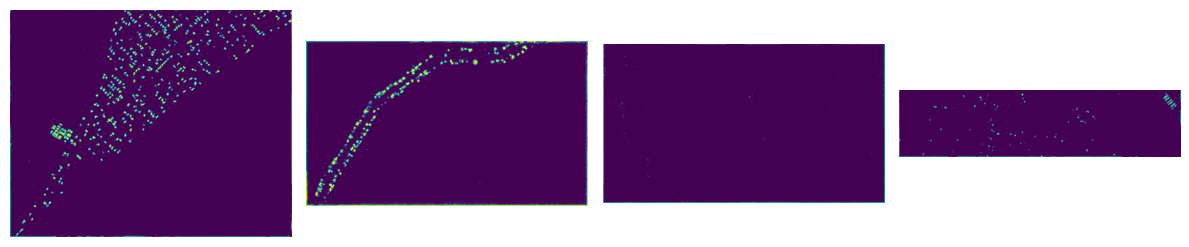

In [45]:
"""
Compare these maps with those shown for the CNN-based maps (cell 6). Houses are still clearly visible (except in KonaMauka,
which is uninhabited), but the false positives have largely been removed.
"""

_, axes = plt.subplots(1, 4, figsize=(12, 4))

for region, ax in zip(regions_to_show, axes):
    with rasterio.open(f'{model_dir}gb_ensemble_prob_{region}.tif', 'r') as f:
        img = f.read()
        ax.imshow(img[0])
        ax.axis('off')
        
plt.tight_layout()

Working on mean_probability maps from /data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/bfgn_output_buildings2/model_runs/ensembles/
Working on CC2
Working on Puako
Working on SKona_B
Working on HBTest
Working on HOVE2
Working on MIL2


FixedFormatter should only be used together with FixedLocator


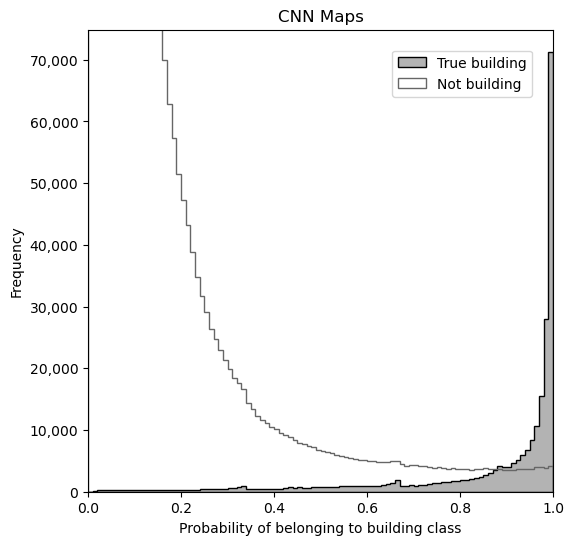

In [46]:
"""
Here's a probability histogram **for the CNN-based maps** (for all the test regions). You can see that the CNN pretty confidently
identified a lot of buildings, but there is a substantial 'tail' of less confidently-identified buildings. If we classified,
for example, everything with >80% probability as a building, we would include a lot of false positives.

NB these are the 1m resolution maps; that's why there are so many more pixels.
"""

cnn_bldg, cnn_notbldg = evalz.probability_hist(model_dir, 'mean_probability', threshold=None,\
                                               title='CNN Maps', legend=True, resolution='')

Working on gb_ensemble_prob maps from /data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/bfgn_output_buildings2/model_runs/ensembles/
Working on MIL2
Working on Puako
Working on CC2
Working on SKona_B
Working on HOVE2
Working on HBTest


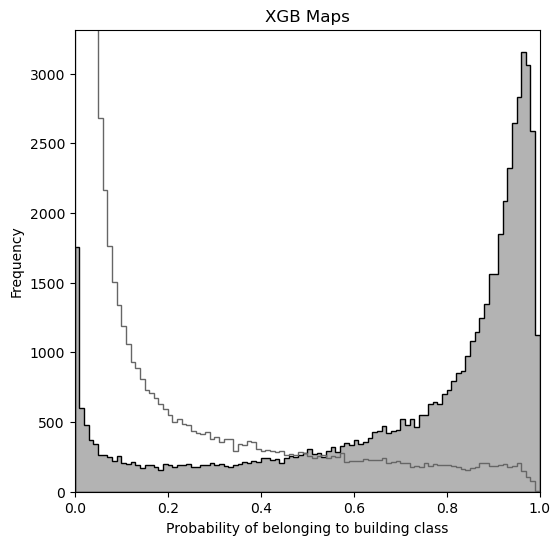

In [47]:
"""
Same thing but for the maps we just created with XGBoost. Buildings are less confidently identified, but we could 'cut'
at lower probabilities with less contamination from false positives. Then, the vector ops (below) help to take care of
the remaining false positives. This figure and the previous one go into Figure 4 in the paper.
"""
xgb_bldg, xgb_notbldg = evalz.probability_hist(model_dir, 'gb_ensemble_prob', threshold=None,\
                                                 title='XGB Maps', legend=False, resolution='lores_')

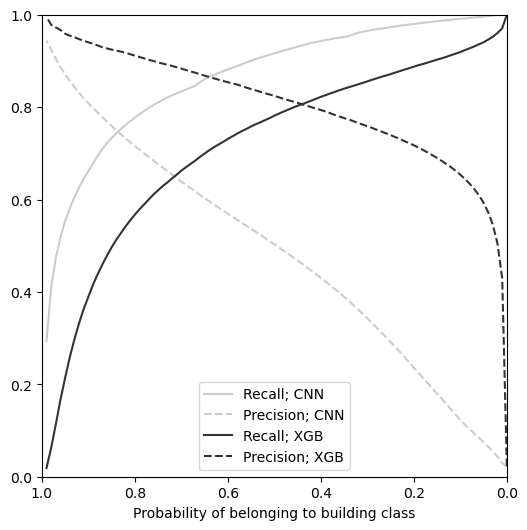

In [48]:
"""
This plot didn't make it into the paper, but it illustrates the points made in the previous cells.
"""

evalz.cumulative(cnn_bldg, cnn_notbldg, xgb_bldg, xgb_notbldg)

In [49]:
%%script echo skipping (files exist)
"""
Create a binary building/not-building map for calculating stats.
"""

for region in all_labelled_data.keys():
    applied_model = f'{base_path}ensembles/gb_ensemble_prob_{region}.tif'
    outfile = f'{base_path}ensembles/gb_ensemble_class_{region}.tif'
    manips.probabilities_to_classes(applied_model, outfile, 0.2, verbose=False)

skipping (files exist)


,Precision,Recall,F1-score,IoU
CC2,0.80,0.81,0.80,0.67
HBTest,0.75,0.95,0.84,0.73
HOVE2,0.70,0.90,0.79,0.65
Hamakua_A,0.75,0.90,0.82,0.69
MIL2,0.66,0.95,0.78,0.64
Puako,0.71,0.83,0.76,0.62
SKona_B,0.67,0.73,0.70,0.53
Mean,0.72,0.87,0.78,0.65


CPU times: user 760 ms, sys: 249 ms, total: 1.01 s
Wall time: 821 ms


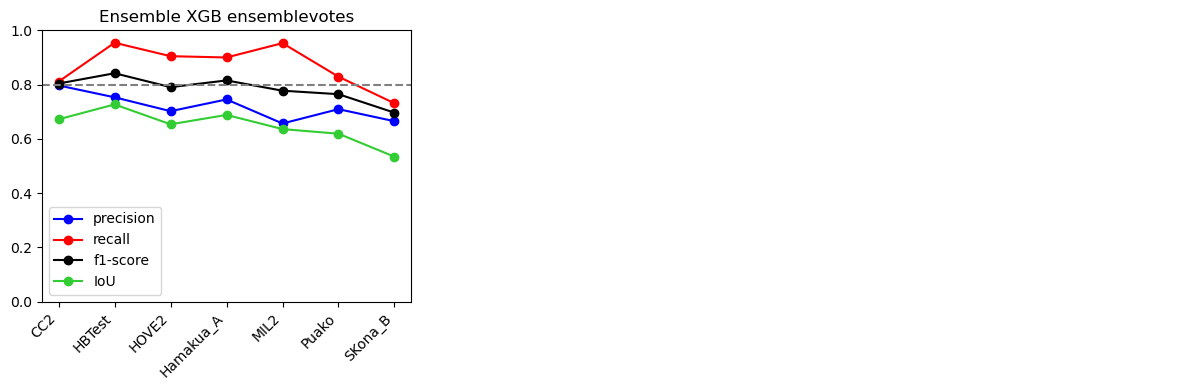

In [50]:
%%time
"""
Stats for the test set. Again, these pixel-based stats aren't in the paper. Here, precision is lower and recall is higher than
for the CNN-based maps, but it all depends where you make the cut when you go from probabilities -> classes.
"""

statsfile = f'{analysis_path}ensemble_test_sets.json'

use_existing = True

if use_existing is False:
    gb_test_stats = {}
    model_dir = f'{base_path}ensembles/'
    gb_test_stats['XGB ensemble'] = stats.raster_stats(model_dir, map_kind=f'gb_ensemble_class',\
                                                          regions=test_sets, resolution='lores_')
    with open(statsfile.replace('tif', 'json'), "w") as f:
        json.dump(gb_test_stats, f)

else:
    with open(statsfile) as f:
        gb_test_stats = json.load(f)
        
stats.plot_raster_stats(gb_test_stats, plot_file=f'ensemble_test_stats.png')
stats.display_raster_stats(gb_test_stats['XGB ensemble'])

## Vectorize and 'clean' the maps

In [51]:
%%script echo skipping (files exist)
"""
First, just vectorize without cleaning, just to get **polygon-based** stats for XGBoost output that can be
compared with the CNN-based and the (upcoming) vector-cleaned versions. These stats are in Table 1 of the paper.
"""

for region in all_labelled_data.keys():
    map_file = f'{base_path}ensembles/gb_ensemble_class_{region}.tif'
    out_file = f'{base_path}ensembles/gb_ensemble_vec_{region}.shp'
    manips.vectorize_only(map_file, out_file)

skipping (files exist)


In [52]:
stats.match_buildings_to_labels(model_dir, map_kind='gb_ensemble_vec')
stats.vector_stats(model_dir, map_kind='gb_ensemble_vec')

,precision,recall,f1-score
CC2,0.82,0.89,0.85
HBTest,0.93,0.97,0.95
HOVE2,0.75,0.90,0.82
Hamakua_A,0.79,0.93,0.85
MIL2,0.48,0.96,0.64
Puako,0.91,0.93,0.92
SKona_B,0.92,0.85,0.88
Mean,0.80,0.92,0.85


In [53]:
%%script echo skipping (files exist)

"""
Now do the whole set of vector ops, which is the final step in the map-making (aside from applying the method to the
entire study areas)
"""

for region in all_labelled_data.keys():
    map_file = f'{base_path}ensembles/gb_ensemble_class_{region}.tif'
    out_file = f'{base_path}ensembles/gb_ensemble_poly_{region}.tif'
    manips.vectorize_and_clean(map_file, out_file, buffers=[-1, 0, 0], minpix=25)

skipping (files exist)


,Precision,Recall,F1-score,IoU
CC2,0.84,0.67,0.75,0.60
HBTest,0.74,0.82,0.78,0.64
HOVE2,0.77,0.78,0.77,0.63
Hamakua_A,0.80,0.63,0.70,0.54
MIL2,0.82,0.80,0.81,0.68
Puako,0.74,0.68,0.71,0.55
SKona_B,0.75,0.60,0.67,0.50
Mean,0.78,0.71,0.74,0.59


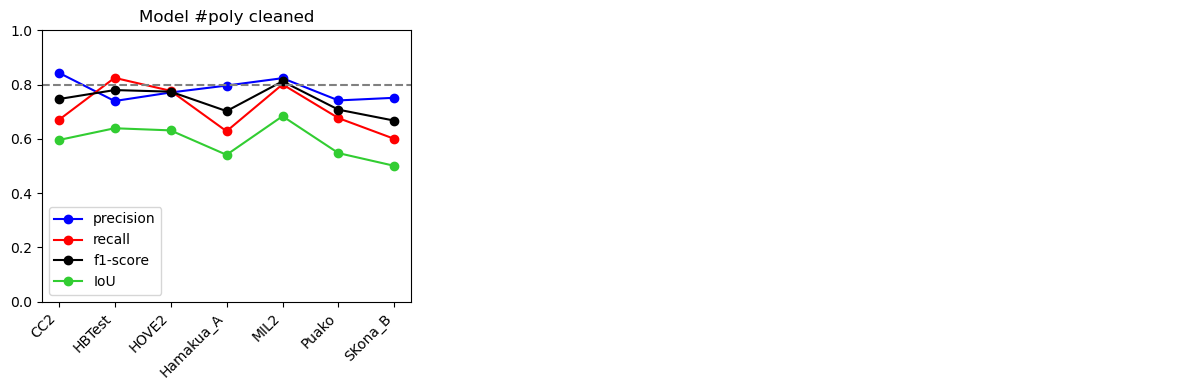

In [54]:
"""
Raster/pixel-based stats again. These are the ones quoted at the end of section 3.2 in the paper.
"""

statsfile = f'{analysis_path}vec_test.json'

use_existing = True

if use_existing is False:
    vec_test_stats = {}
    model_dir = f'{base_path}ensembles/'
    vec_test_stats['poly cleaned'] = stats.raster_stats(model_dir, map_kind=f'gb_ensemble_bounds',\
                                                        regions=test_sets, resolution='lores_')
    with open(statsfile.replace('tif', 'json'), "w") as f:
        json.dump(vec_test_stats, f)

else:
    with open(statsfile) as f:
        vec_test_stats = json.load(f)
        
stats.plot_raster_stats(vec_test_stats, plot_file='vec_test_stats.png')
stats.display_raster_stats(vec_test_stats['poly cleaned'])

In [55]:
"""
Now get our vector-based stats, as reported in Table 1. In the following cell we'll also create Figure 6.
"""

stats.match_buildings_to_labels(model_dir, map_kind='gb_ensemble_bounds')
stats.vector_stats(model_dir, map_kind='gb_ensemble_bounds')

,precision,recall,f1-score
CC2,0.99,0.79,0.88
HBTest,1.00,0.95,0.97
HOVE2,0.95,0.83,0.89
Hamakua_A,0.98,0.86,0.92
MIL2,1.00,0.94,0.97
Puako,1.00,0.89,0.94
SKona_B,1.00,0.72,0.84
Mean,0.99,0.85,0.92


invalid value encountered in true_divide
invalid value encountered in true_divide


,Bin start,Recall,Precision
0,50,0.42,0.92
1,70,0.56,0.98
2,90,0.72,0.97
3,110,0.79,0.98
4,130,0.84,1.00
5,150,0.94,0.98
6,170,0.89,0.99
7,190,0.96,1.00
8,210,1.00,1.00
9,230,0.97,1.00


The 0.25 quantile of building area is 133 sq m
The 0.5 quantile of building area is 218 sq m
The 0.75 quantile of building area is 290 sq m
14% of labeled buildings have area < 90 sq m
Median absolute error on building size = 15%
CPU times: user 1min 12s, sys: 403 ms, total: 1min 12s
Wall time: 1min 12s


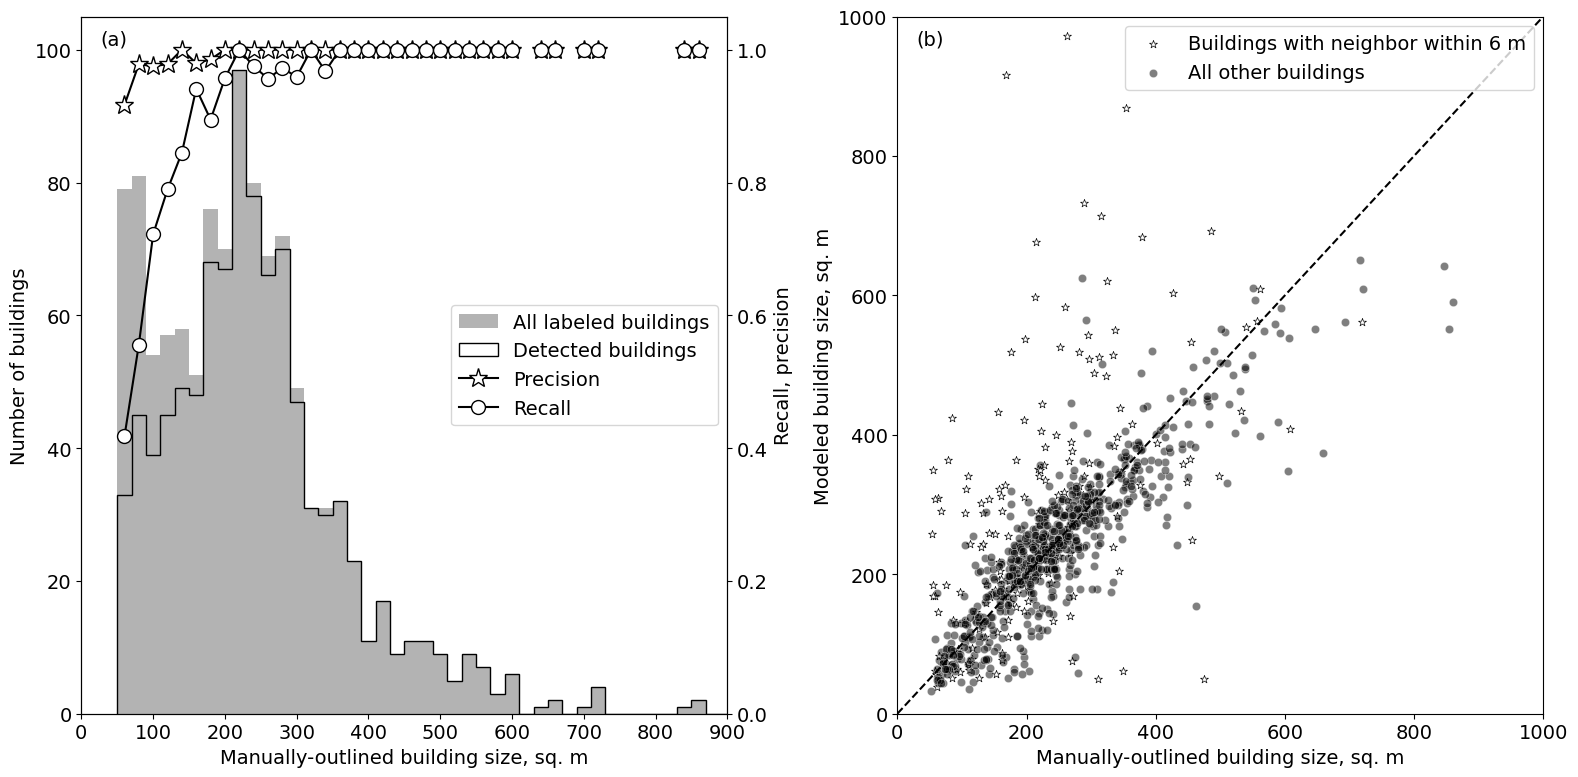

In [56]:
%%time
stats.building_size_plots(sep=6)

## Apply to whole tiles

This should really be a separate notebook! The maps were visually inspected and found to be generally good. Worst performance is probably in some of the coastal resort areas where buildings have complex roofs of shapes and sizes that are not common in the training data.

In [ ]:
manips = run_xgb.MapManips(None, None)

### South Kona region

In [ ]:
tiles = ['024', '025', '030', '031']
boundary_file = f'SKona_epsg32605_buf.shp'

In [ ]:
%%script echo skipping (files exist)
#%%time 15 mins or so
"""
Create mean CNN maps and interpolate them to 2m pixel size
"""

for tile in tiles:
    apply.cnn_average_interpolate(tile=tile, combos=list(range(9)))

In [ ]:
%%script echo skipping (files exist)
#%%time
"""
Apply the saved XGB models to the reflectance, interpolated mean CNN map, and canopy height map for each tile
"""

for tile in tiles:
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run1.pkl', bnorm=True)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run2.pkl', bnorm=True)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run3.pkl', bnorm=False)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run4.pkl', bnorm=False)

In [ ]:
%%script echo skipping (files exist)
"""
Average the four runs and convert probabilities to classes
"""

for tile in tiles:
    apply.xgb_ensemble_classes(tile, threshold=0.2)

In [ ]:
%%script echo skipping (files exist)
"""
Mosaic the classmap tiles and crop to the study region boundary
"""

boundary_file = f'SKona_epsg32605_buf.shp'
apply.mosaic_and_crop(tiles, boundary_file=boundary_file, region='SKona')

In [ ]:
%%script echo skipping (files exist)
"""
Carry out the vector cleaning ops
"""

map_file = f'{base_path}ensembles/SKona_xgb_mosaic.tif'
out_file = f'{base_path}ensembles/SKona_poly.tif'
manips.vectorize_and_clean(map_file, out_file, buffers=[-1, 0, 0], minpix=25, mask_edges=False)

In [ ]:
%%script echo skipping (files exist)
"""
Copy the final map to the final_maps directory and give it a better name
"""

src = f'{base_path}ensembles/SKona_bounds.tif'
dst = '/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/final_maps/SKona.tif'
shutil.copyfile(src, dst)
shutil.copyfile(src.replace('.tif', '.hdr'), dst.replace('.tif', '.hdr'))
#shutil.copyfile(src, dst+'.aux.xml')

### North Hilo-Hamakua region

In [ ]:
tiles = ['008', '009', '014', '015', '016', '021', '022']
boundary_file = f'NHiloHamakua_epsg32605.shp'

In [ ]:
%%script echo skipping (files exist)

for tile in tiles:
    apply.cnn_average_interpolate(tile=tile, combos=list(range(9)))

In [ ]:
%%script echo skipping (files exist)
%%time

for tile in tiles:
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run1.pkl', bnorm=True)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run2.pkl', bnorm=True)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run3.pkl', bnorm=False)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run4.pkl', bnorm=False)

In [ ]:
%%script echo skipping (files exist)
for tile in tiles:
    apply.xgb_ensemble_classes(tile, threshold=0.2)

In [ ]:
%%script echo skipping (files exist)
apply.mosaic_and_crop(tiles, boundary_file=boundary_file, region='NHiloHamakua')

In [ ]:
%%script echo skipping (files exist)
map_file = f'{base_path}ensembles/NHiloHamakua_xgb_mosaic.tif'
out_file = f'{base_path}ensembles/NHiloHamakua_poly.tif'
manips.vectorize_and_clean(map_file, out_file, buffers=[-1, 0, 0], minpix=25, mask_edges=False)

In [ ]:
%%script echo skipping (files exist)
src = f'{base_path}ensembles/NHiloHamakua_bounds.tif'
dst = '/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/final_maps/NHiloHamakua.tif'
shutil.copyfile(src, dst)
shutil.copyfile(src.replace('.tif', '.hdr'), dst.replace('.tif', '.hdr'))
shutil.copyfile(src+'.aux.xml', dst+'.aux.xml')

### N. Kona - S. Kohala region

In [ ]:
tiles = ['007', '012', '013', '018', '019', '020']
boundary_file = f'NKonaSKohala_epsg32605_buf.shp'

In [ ]:
%%script echo skipping (files exist)
for tile in tiles:
    apply.cnn_average_interpolate(tile=tile, combos=list(range(9)))

In [ ]:
%%script echo skipping (files exist)
%%time

for tile in tiles:
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run1.pkl', bnorm=True)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run2.pkl', bnorm=True)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run3.pkl', bnorm=False)
    apply.loop_over_windows(tile=tile, bad_bands=bad_bands, model='gb_run4.pkl', bnorm=False)

In [ ]:
%%script echo skipping (files exist)
for tile in tiles:
    apply.xgb_ensemble_classes(tile, threshold=0.2)

In [ ]:
%%script echo skipping (files exist)
#this region also contains tiles 8 and 14, which were prepared earlier (they're also in Hilo-Hamakua)
tiles = ['007', '008', '012', '013', '014', '018', '019', '020'] 
apply.mosaic_and_crop(tiles, boundary_file=boundary_file, region='NKonaSKohala')

In [ ]:
%%script echo skipping (files exist)
map_file = f'{base_path}ensembles/NKonaSKohala_xgb_mosaic.tif'
out_file = f'{base_path}ensembles/NKonaSKohala_poly.tif'
manips.vectorize_and_clean(map_file, out_file, buffers=[-1, 0, 0], minpix=25, mask_edges=False)

In [ ]:
%%script echo skipping (files exist)
src = f'{base_path}ensembles/NKonaSKohala_bounds.tif'
dst = '/data/gdcsdata/HawaiiMapping/ProjectFiles/Rachel/final_maps/NKonaSKohala.tif'
shutil.copyfile(src, dst)
shutil.copyfile(src.replace('.tif', '.hdr'), dst.replace('.tif', '.hdr'))
shutil.copyfile(src+'.aux.xml', dst+'.aux.xml')

### With RGB images instead of spectra

A reviewer asked what would happen if we used RGB images instead of spectroscopy, so let's do that here. This isn't part of the paper.

In [57]:
"""
Define the data that will go into the XGBoost model. Here it's RGB bands from the spectroscopy
dataset, plus canopy height and the LiDAR+CNN ensemble map
"""

bad_bands = [0] #reject band 0; it's not bad, it's just the 'IR' (861 nm) band
xvars = {'irgb': [n for n in range(4) if n not in bad_bands], 'lores_model': ['model_prob'],\
         'tch': ['tch']}

In [58]:
"""
Some definitions etc.
"""

n_iter = 10
run_id = 'run0'
brightness_norm = False

training_sets = {'HOVE1': 'tile031_3125_11250',\
                           'CC1': 'tile024_10000_3125',\
                           'MIL1': 'tile030_10000_5625',\
                           'Hamakua': 'tile016_0_4375',\
                           'KParadise': 'KParadise',\
                           'WAI1': 'Waikoloa1',\
                           'KK1': 'Kukio1',\
                           'Waimea': 'Waimea',\
                           'HBLower': 'HBLower',\
                           'SKona_A': 'SKona_TestA',\
                           'KonaMauka': 'KonaMauka',\
                           'CCTrees': 'tile024_10000_4375'}

test_sets = {'HBTest': 'HBTest',\
                       'HOVE2': 'tile031_2500_11250',\
                       'MIL2': 'tile030_9375_5625',\
                       'CC2': 'tile024_10000_2500',\
                       'Hamakua_A': 'Hamakua_testA',\
                       'Puako': 'Puako',\
                       'SKona_B': 'SKona_TestB'}

all_labelled_data = {**training_sets, **test_sets}


utils = run_xgb.Utils(all_labelled_data)

manips = run_xgb.MapManips(model_output_root=base_path,\
                               all_labelled_data=all_labelled_data)

evalz = run_xgb.Evaluate(model_output_root=base_path, training_sets=training_sets,\
                             test_sets = test_sets, all_labelled_data=all_labelled_data)

stats = run_xgb.Stats(model_output_root=base_path, test_sets=test_sets,\
                          all_labelled_data=all_labelled_data,\
                          analysis_path=analysis_path)

In [59]:
%%time
"""
Create the dataset to which the GB model will be fit. This contains all pixels from the training data sets, minus
those for which there is no spectroscopy data.
"""

use_existing = True
if use_existing:

    with open(f'{model_dir}X_{run_id}.pkl', "rb") as f:
        X = pickle.load(f)
    with open(f'{model_dir}y_{run_id}.pkl', "rb") as f:
        y = pickle.load(f)
else:
    X, y = evalz.get_vars_from_rasters(xvars=xvars, bad_bands=bad_bands, mask_shade=True,\
                                       bnorm=brightness_norm, model_dir=model_dir, run_id=run_id)

CPU times: user 62.1 ms, sys: 556 ms, total: 618 ms
Wall time: 1.81 s


In [60]:
use_existing = True
gb_file = f'{model_dir}gb_{run_id}.pkl'

if use_existing:
    with open(gb_file, "rb") as f:
        gb = pickle.load(f)
else:
    gb = evalz.ml_classify(X, y, n_iter=n_iter, scoring='recall', save_to=gb_file)


[14:47:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/gbm/gbtree.cc:390: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[14:47:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1665562897727/work/src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


In [61]:
%%script echo skipping (files exist)

#apply the model
out_prefix = f'{base_path}ensembles/gb_prob_{run_id}'
manips.gb_prob_to_raster(gb, xvars=xvars, bad_bands=bad_bands, out_prefix=out_prefix,\
                                   model_dir=model_dir, bnorm=brightness_norm)

#convert to binary map
for region in all_labelled_data.keys():
    applied_model = f'{base_path}ensembles/gb_prob_{run_id}_{region}.tif'
    outfile = f'{base_path}ensembles/gb_class_{run_id}_{region}.tif'
    manips.probabilities_to_classes(applied_model, outfile, 0.2, verbose=False)

skipping (files exist)


In [62]:
%%script echo skipping (files exist)

#vectorize and get stats
for region in all_labelled_data.keys():
    map_file = f'{base_path}ensembles/gb_class_{run_id}_{region}.tif'
    out_file = f'{base_path}ensembles/gb_vec_{run_id}_{region}.shp'
    manips.vectorize_only(map_file, out_file)


skipping (files exist)


In [63]:
#Compare with stats in cell 54 (XGBoost incl spectroscopy, vectorize only without 'cleaning')
#Precision and f1-score are lower but not all that much lower so not using whole spectra seems viable

stats.match_buildings_to_labels(model_dir, map_kind=f'gb_class_{run_id}')
stats.vector_stats(model_dir, map_kind=f'gb_vec_{run_id}')

,precision,recall,f1-score
CC2,0.71,0.89,0.79
HBTest,0.86,0.97,0.91
HOVE2,0.80,0.89,0.84
Hamakua_A,0.70,0.93,0.80
MIL2,0.45,0.96,0.62
Puako,0.76,0.93,0.84
SKona_B,0.91,0.79,0.85
Mean,0.74,0.91,0.81
